In [88]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib import pyplot as plt
import dvu
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import viz
import numpy as np
import torch
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
import data
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all different models across dsets

In [89]:
!ls ../reports

cell_level_res.csv
cell_level_res_successful.csv
cell_level_res_successful_dynamin.csv
dataset_level_res.csv
dataset_level_res_successful.csv
dataset_level_res_successful_dynamin.csv
data_size_stability_10_successful_dynamin.pkl
readme.md


In [90]:
suffix = '_successful_dynamin' # '_successful', _successful_dynamin # '' choose which outcome to use

In [91]:
res = pd.read_csv(f"../reports/dataset_level_res{suffix}.csv", index_col=0)
res = res.round(3)
res = res[[c for c in res.columns if 'balanced' not in c]]
res = res.transpose()
res = res[['gb_basic', 'rf_basic', 'svm_basic', 'svm_dasc', 'lstm']]
# res.to_latex()

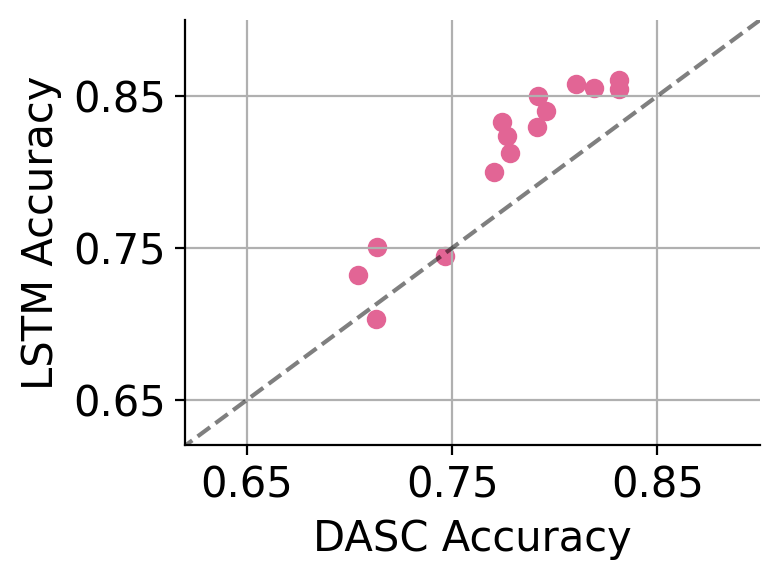

In [92]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
plt.figure(dpi=200, figsize=(4, 3))
plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values, color='#E26595')
plt.xlim((0.62, 0.9))
plt.ylim((0.62, 0.9))
plt.xticks([0.65, 0.75, 0.85])
plt.yticks([0.65, 0.75, 0.85])
plt.xlabel("DASC Accuracy")
plt.ylabel("LSTM Accuracy")
plt.grid()
# plt.title("Classification accuracy", fontsize=15)
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('acc_lstm_dasc')
plt.show()

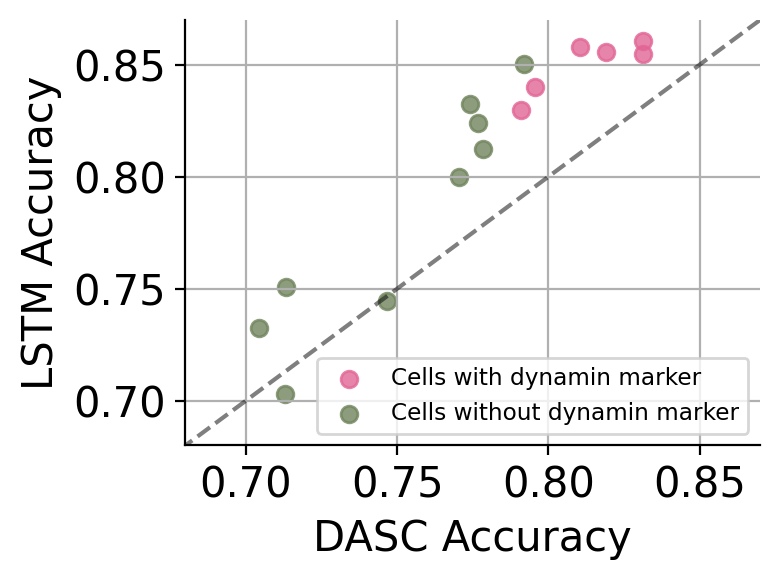

In [93]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
dynamin_cells = [f'{k}_accuracy' for k in config.DSETS['clath_aux_dynamin']['test']]
non_dynamin_cells = [c for c in res.columns if c not in dynamin_cells]
baseline = 'svm_dasc'
plt.figure(dpi=200, figsize=(4, 3))

plt.scatter(res.loc[baseline][dynamin_cells].values, 
            res.loc['lstm'][dynamin_cells].values, 
            color='#E26595',
            #s=res.loc['num_tracks'][dynamin_cells].values/30, 
            label='Cells with dynamin marker',
            alpha=.8)
plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
            res.loc['lstm'][non_dynamin_cells].values, 
            color='#6F845C',
            #s=res.loc['num_tracks'][non_dynamin_cells].values/30, 
            label='Cells without dynamin marker',
            alpha=.8)
#plt.figure(dpi=200, figsize=(4, 3))
#plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values, color='#E26595')
plt.xlim((0.68, 0.87))
plt.ylim((0.68, 0.87))
# plt.xticks([0.7, 0.75, 0.85])
# plt.yticks([0.7, 0.75, 0.85])
plt.xlabel("DASC Accuracy")
plt.ylabel("LSTM Accuracy")
plt.legend(loc='lower right', fontsize='small')
# plt.title("Test accuracy", fontsize=15)
plt.grid()
# plt.title("Classification accuracy", fontsize=15)
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('acc_lstm_dasc')
plt.show()

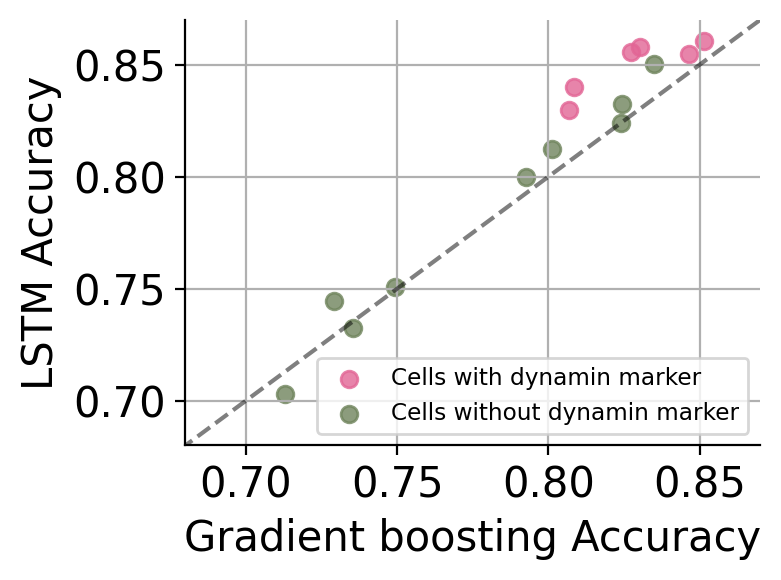

In [94]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
dynamin_cells = [f'{k}_accuracy' for k in config.DSETS['clath_aux_dynamin']['test']]
non_dynamin_cells = [c for c in res.columns if c not in dynamin_cells]
baseline = 'gb_basic'
plt.figure(dpi=200, figsize=(4, 3))

plt.scatter(res.loc[baseline][dynamin_cells].values, 
            res.loc['lstm'][dynamin_cells].values, 
            color='#E26595',
            #s=res.loc['num_tracks'][dynamin_cells].values/30, 
            label='Cells with dynamin marker',
            alpha=.8)
plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
            res.loc['lstm'][non_dynamin_cells].values, 
            color='#6F845C',
            #s=res.loc['num_tracks'][non_dynamin_cells].values/30, 
            label='Cells without dynamin marker',
            alpha=.8)
#plt.figure(dpi=200, figsize=(4, 3))
#plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values, color='#E26595')
plt.xlim((0.68, 0.87))
plt.ylim((0.68, 0.87))
# plt.xticks([0.7, 0.75, 0.85])
# plt.yticks([0.7, 0.75, 0.85])
plt.xlabel("Gradient boosting Accuracy")
plt.ylabel("LSTM Accuracy")
plt.legend(loc='lower right', fontsize='small')
# plt.title("Test accuracy", fontsize=15)
plt.grid()
# plt.title("Classification accuracy", fontsize=15)
plt.plot((0.6, 0.95), (0.6, 0.95), '--', color='k', alpha=.5)
viz.savefig('acc_lstm_gb')
plt.show()

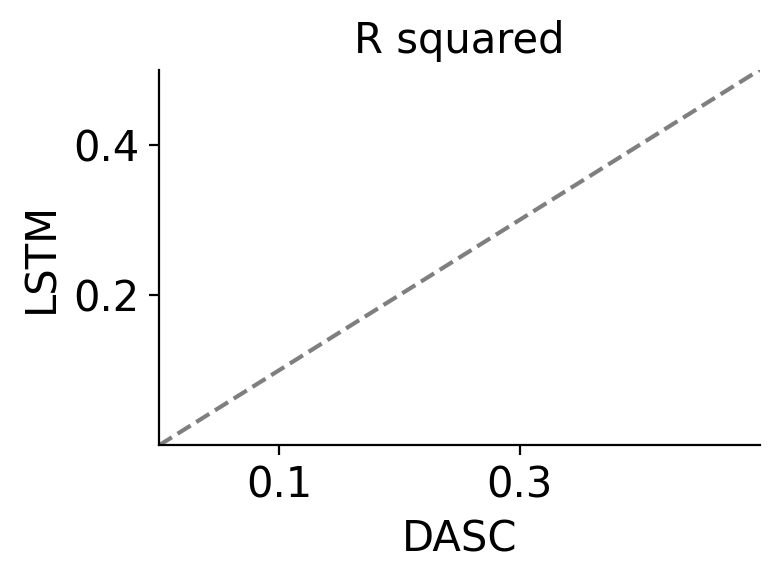

In [67]:
res = res[[c for c in res.columns if c.endswith('r2')]]
plt.figure(dpi=200, figsize=(4, 3))
plt.scatter(res.loc['svm_dasc'].values, res.loc['lstm'].values)
plt.xlim((0, 0.5))
plt.ylim((0, 0.5))
plt.xticks([0.1, 0.3])
plt.yticks([0.2, 0.4])
plt.xlabel("DASC")
plt.ylabel("LSTM")
plt.title("R squared", fontsize=15)
plt.plot((0, 0.5), (0, 0.5), '--', color='k', alpha=.5)
plt.show()

## plot accs of models trained on subsamples data

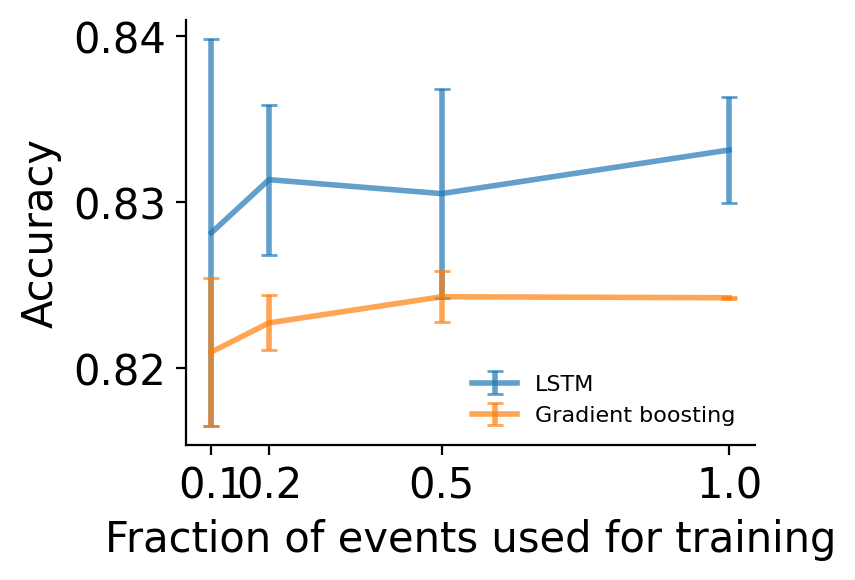

In [74]:
suffix = '_successful_dynamin' # '_successful', _successful_dynamin # '' choose which outcome to use
res = pkl.load(open(f'../reports/data_size_stability_10{suffix}.pkl', 'rb'))
fig = plt.figure(dpi=200, figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
accs = {'gb': np.zeros(4), 'lstm': np.zeros(4)}
stds = {'gb': np.zeros(4), 'lstm': np.zeros(4)}
for i, k in enumerate([10, 5, 2, 1]):
    #if i==0:
    #    plt.scatter([i-0.1]*k, [0.817], color='#E26595', marker='*', label='gb')
    #    plt.scatter([i+0.1]*k, [0.841], color='#8DA37B', marker='*', label='lstm')
    #else:
    #plt.scatter([i-0.1]*10, [res[(k, j, 'gb')] for j in range(10)], marker='*', color='#E26595')
    #plt.scatter([i+0.1]*10, [res[(k, j, 'lstm')] for j in range(10)], marker='*', color='#8DA37B')
    for m in ['gb', 'lstm']:
        errs = np.array([res[(k, j, m)] for j in range(10)])
        accs[m][i] = np.mean(errs)
        stds[m][i] = np.std(errs)
#plt.plot([0.1, 0.2, 0.5, 1], accs['gb'])
#plt.plot([0.1, 0.2, 0.5, 1], accs['lstm'])
plt.errorbar([0.1, 0.2, 0.5, 1], accs['lstm'], stds['lstm'], linewidth=2,  alpha=.7, capsize=3, label='LSTM')
#plt.errorbar([0.1, 0.2, 0.5, 1], accs['lstm'])
plt.errorbar([0.1, 0.2, 0.5, 1], accs['gb'], stds['gb'], linewidth=2, alpha=.7, capsize=3, label='Gradient boosting')
#plt.errorbar([0.1, 0.2, 0.5, 1], accs['gb'])
plt.xticks([0.1, 0.2, 0.5, 1.0])

plt.xlabel("Fraction of events used for training")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', fontsize=8, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.yticks([0.8, 0.82, 0.84])
plt.show()

# look at accs for different models

In [ ]:
dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak', 'clath_aux_dynamin']
splits = ['test']
#feat_names = [''] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
length = 40
padding = 'end'
feat_name = 'X_same_length_extended_normalized' # include buffer X_same_length_normalized
outcome = 'Y_sig_mean_normalized'
                

dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, 
                                         splits=splits, 
                                         lifetime_threshold=-1,
                                         length=length,
                                         normalize=False,
                                         padding=padding)

In [ ]:
def get_all_scores(y, preds, y_reg, df, dataset_level_res, cell_level_res):
    scorers = {
        'balanced_accuracy': metrics.balanced_accuracy_score, 'accuracy': metrics.accuracy_score,
        'roc_auc': metrics.roc_auc_score, 'r2': metrics.r2_score,
        'corr': scipy.stats.pearsonr
    }
    for metric in scorers:
        if 'accuracy' in metric:
            acc = scorers[metric](y, (preds > 0))                   
            dataset_level_res[f'{k}_{metric}'].append(acc)
        elif metric == 'roc_auc':
            try:
                dataset_level_res[f'{k}_{metric}'].append(scorers[metric](y, preds))
            except:
                dataset_level_res[f'{k}_{metric}'].append(np.nan)
        elif metric == 'r2':
            dataset_level_res[f'{k}_{metric}'].append(scorers[metric](y_reg, preds))
        else:
            dataset_level_res[f'{k}_{metric}'].append(scorers[metric](y_reg, preds)[0])
    '''
    for cell in set(df['cell_num']):
        cell_idx = np.where(df['cell_num'].values == cell)[0]
        y_cell = y[cell_idx]
        y_reg_cell = y_reg[cell_idx]
        preds_cell = preds[cell_idx]
        for metric in scorers:
            if 'accuracy' in metric:
                acc = scorers[metric](y_cell, (preds_cell > 0))                   
                cell_level_res[f'{cell}_{metric}'].append(acc)
            elif metric == 'roc_auc':
                try:
                    cell_level_res[f'{cell}_{metric}'].append(scorers[metric](y_cell, preds_cell))
                except:
                    cell_level_res[f'{cell}_{metric}'].append(np.nan)
            elif metric == 'r2':
                cell_level_res[f'{cell}_{metric}'].append(scorers[metric](y_reg_cell, preds_cell))
            else:
                cell_level_res[f'{cell}_{metric}'].append(scorers[metric](y_reg_cell, preds_cell)[0]) 
    '''
    
dataset_level_res = defaultdict(list)
cell_level_res = defaultdict(list)
LIFETIME_CHUNKS = [(5, 10), (10, 15), (15, 20), (20, 30), (30, 40), (40, 60), (60, 80), (80, 120), (120, 10000)]
TRAINING_LIFETIME_THRESHES = [5, 10, 15, 'original', 'baseline']
for lifetime_threshold in tqdm(TRAINING_LIFETIME_THRESHES):
    
    ds = {(k, v): dfs[(k, v)]
          for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
          if v == 'test'
         }
    
    # load model
    if lifetime_threshold == 'original' or lifetime_threshold == 'baseline': # for baseline doesn't matter which model we load, will just alawys predict 0 below
        results = pkl.load(open(f'../models/dnn_full_long_normalized_across_track_1_feat_dynamin.pkl', 'rb'))
    else:
        results = pkl.load(open(f'../models/dnn_fit_extended_lifetimes>{lifetime_threshold}.pkl', 'rb'))
    dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm', track_name=feat_name)
    dnn.model.load_state_dict(results['model_state_dict'])

    
    # evaluate on all data
    '''
    for i, (k, v) in enumerate(ds.keys()):
        df = ds[(k, v)]
        X = df[[feat_name]]
        y_reg = df['Y_sig_mean_normalized'].values
        y = df['y_consec_thresh'].values
        preds = dnn.predict(X)
        get_all_scores(y, preds, y_reg, df, dataset_level_res, cell_level_res)
    '''
        
        
    # lifetime chunks
    for chunk in LIFETIME_CHUNKS:
        for i, (k, v) in enumerate(ds.keys()):
            df = ds[(k, v)]
            df = df[(df.lifetime > chunk[0]) & (df.lifetime <= chunk[1])]
            X = df[[feat_name]]
            # print(chunk, X.shape)
            if X.shape[0] > 1:
                y_reg = df['Y_sig_mean_normalized'].values
                y = df['y_consec_thresh'].values
                
                if lifetime_threshold == 'baseline':
                    preds = np.zeros(y.size)
                else:
                    preds = dnn.predict(X)
                get_all_scores(y, preds, y_reg, df, dataset_level_res, cell_level_res)

In [ ]:
LIFETIME_CHUNK_LABS = [str(s) for s in LIFETIME_CHUNKS]
R, C = 2, 3
plt.figure(figsize=(20, 14), facecolor='w')
for i, dset in tqdm(enumerate(dsets)):
    ax = plt.subplot(R, C, i + 1)
    k = f'{dset}_accuracy'
    acc = np.array(dataset_level_res[k]).reshape(len(TRAINING_LIFETIME_THRESHES), len(LIFETIME_CHUNKS))
    for i, thresh in enumerate(TRAINING_LIFETIME_THRESHES):
        plt.plot(acc[i], label=thresh)
    plt.xticks(range(len(LIFETIME_CHUNK_LABS)), labels=LIFETIME_CHUNK_LABS, rotation='60')
    dvu.line_legend(adjust_text_labels=True)
    plt.title(dset)
    plt.ylabel('Accuracy')
    plt.xlabel('Lifetimes')
    if i < C:
        ax.get_xaxis().set_visible(False)
viz.savefig('vary_lifetime_thresh')
plt.show()

# compare different dnn models

In [ ]:
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized', 'y_consec_thresh']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
# dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, 
#                                          splits=splits, 
#                                          lifetime_threshold=15,
#                                          length=length,
#                                          normalize=False,
#                                          padding=padding)
ds = {(k, v): dfs[(k, v)]
          for (k, v) in sorted(dfs.keys(), key=lambda x: x[1] + x[0])
          if v == 'test'
         }

In [ ]:
accs = {l: [] for l in TRAINING_LIFETIME_THRESHES}
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    for lifetime_threshold in TRAINING_LIFETIME_THRESHES:
        # for baseline doesn't matter which model we load, will just alawys predict 0 below
        if lifetime_threshold == 'original' or lifetime_threshold == 'baseline':
            feat_name = 'X_same_length_normalized'
            results = pkl.load(open(f'../models/dnn_full_long_normalized_across_track_1_feat_dynamin.pkl', 'rb'))
        else:
            feat_name = 'X_same_length_extended_normalized'
            results = pkl.load(open(f'../models/dnn_fit_extended_lifetimes>{lifetime_threshold}.pkl', 'rb'))
        dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=0, arch='lstm', track_name=feat_name)
        dnn.model.load_state_dict(results['model_state_dict'])
        
        X = df[[feat_name]]
        y_reg = df['Y_sig_mean_normalized'].values
        y = df['y_consec_thresh'].values
        if lifetime_threshold == 'baseline':
            preds = np.zeros(y.size)
        else:
            preds = dnn.predict(X)
        acc = np.mean((preds > 0) == y)
#         print('dset', k, 'model\t', lifetime_threshold, '\t', acc.round(3))
        accs[lifetime_threshold].append(acc)
daccs = pd.DataFrame.from_dict(accs)
daccs.index = [k for k,v in ds.keys()]
print(daccs.to_latex())

# compare different defns

In [ ]:
for i, (k, v) in enumerate(ds.keys()):
    df = ds[(k, v)]
    df = outcomes.add_aux_dyn_outcome(df)
#     if 'Z' in df.keys():
#         plt.hist(df['Z_max'])
    print(k, np.mean(df['successful']), np.mean(df['y_consec_thresh']))